In [ ]:
# Please update this if necessary

from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/MyDrive/ECE5242_AutonomousSystems/Project2

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/ECE5242_AutonomousSystems/Project2


In [ ]:
!ls

combined_likelihood_sequence_plot.png  combined_trained_model_wave.pkl
combined_trained_model_beat3.pkl       ECE5242Proj2-test
combined_trained_model_beat4.pkl       ECE5242Proj2-train
combined_trained_model_circle.pkl      ECE5242Proj2-train-additional
combined_trained_model_eight.pkl       ias_proj2.ipynb
combined_trained_model_inf.pkl	       likelihoods_sequences_combined.pkl


In [ ]:
gestures_list = ['beat3','beat4','circle','eight','inf','wave']

In [ ]:
train_repeated_gestures_folder_path = 'ECE5242Proj2-train/'
train_single_gesture_folder_path = 'ECE5242Proj2-train-additional/'

In [ ]:
# Please update this directory name if necessary
test_folder_path = 'ECE5242Proj2-test/'

Load Training Data

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
import os
import glob
import numpy as np
from sklearn.cluster import KMeans
from scipy.special import logsumexp

In [ ]:
import pickle
import matplotlib.pyplot as plt

In [ ]:
def load_data(folder_path, train=True):
    data_frames = []
    if train:
        for gesture in gestures_list:
            search_pattern = os.path.join(folder_path, f"{gesture}*.txt")
            file_paths = glob.glob(search_pattern)
            file_paths_sorted = sorted(file_paths)
            data_lists = [np.loadtxt(file_path) for file_path in file_paths_sorted]
            data_frame = pd.DataFrame(np.concatenate(data_lists), columns=['t', 'Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az'])
            data_frame['label'] = gesture
            data_frames.append(data_frame)
    else:
        search_pattern = os.path.join(folder_path, "*.txt")
        file_paths = glob.glob(search_pattern)
        file_paths_sorted = sorted(file_paths)
        print(file_paths_sorted)
        for i, file_path in enumerate(file_paths_sorted):
            data_list = np.loadtxt(file_path)
            data_frame = pd.DataFrame(data_list, columns=['t', 'Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az'])
            data_frame['label'] = file_path  # Assigning label based on file index
            data_frames.append(data_frame)

    return data_frames

In [ ]:
train_repeated_data = load_data(train_repeated_gestures_folder_path)
train_single_data = load_data(train_single_gesture_folder_path)

Set Hyperparameters

In [ ]:
hidden_states = 30
num_centroids = 100
obs_types = 100
MAX_ITER= 100
EPSILON = 1e-10
print_steps = False

Train the Models for each Gesture

In [ ]:
# Discretize the raw sensor data using k-means clustering
combined_data = pd.concat(train_repeated_data, ignore_index=True)
features = combined_data[['Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az']]
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
kmeans = KMeans(n_clusters=num_centroids, init='k-means++', random_state=42)
kmeans.fit(features_imputed)
combined_data['cluster'] = kmeans.labels_

for i, df in enumerate(train_repeated_data):
    start_idx = sum(len(df) for df in train_repeated_data[:i])
    end_idx = start_idx + len(df)
    df['cluster'] = combined_data.iloc[start_idx:end_idx]['cluster'].values

for i, df in enumerate(train_single_data):
    start_idx = sum(len(df) for df in train_single_data[:i])
    end_idx = start_idx + len(df)
    df['cluster'] = combined_data.iloc[start_idx:end_idx]['cluster'].values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def forward(log_trans_mat,log_em_mat,log_init_state,seq_obs):
    # init_state is num_h_states entries
    # em_mat is num_h_states rows by num_obs_types cols
    len_seq = len(seq_obs)
    num_h_states = len(log_trans_mat)
    log_alpha = np.empty((num_h_states,len_seq))
    log_alpha[:,0] = log_init_state + log_em_mat[:, (seq_obs[0])]
    for t in range(1,len_seq):
        obs = seq_obs[t]
        log_alpha[:,t] = logsumexp(log_alpha[:,t-1][:, np.newaxis] + log_trans_mat, axis = 0) + log_em_mat[:,obs]
    if(print_steps):
        print('alpha is \n {}'.format(np.exp(log_alpha)))
    return log_alpha

# backward
def backward(log_trans_mat,log_em_mat,seq_obs):
    len_seq = len(seq_obs)
    num_h_states = len(log_trans_mat)
    log_beta = np.empty((num_h_states,len_seq))
    log_beta[:, len_seq - 1] = np.log(np.ones((num_h_states,)))
    for t in range(len_seq - 2, -1, -1):
        log_beta[:, t] = logsumexp(log_trans_mat + log_em_mat[:, seq_obs[t+1]] + log_beta[:, t+1], axis=1)
    if(print_steps):
        print('beta is \n {}'.format(np.exp(log_beta)))
    return log_beta

# log likelihood of data
def calc_log_likelihood(log_alpha_mat):
    return logsumexp(log_alpha_mat[:,-1])

def gamma(log_alpha_mat,log_beta_mat):
    log_gamma = log_alpha_mat + log_beta_mat
    log_gamma_normalized = log_gamma - logsumexp(log_gamma,axis=0)
    if(print_steps):
        print('gamma is \n {}'.format(np.exp(log_gamma_normalized)))
    return log_gamma_normalized

# ksi
def ksi(log_alpha_mat,log_beta_mat,log_trans_mat,log_em_mat,seq_obs):
    num_h_states = len(log_trans_mat)
    len_obs_seq = len(seq_obs)
    log_ksi = np.empty((len_obs_seq-1,num_h_states,num_h_states))
    # print('shape of ksi is {}'.format(log_ksi.shape))
    for t in range(len_obs_seq-1):
        temp = log_trans_mat + log_alpha_mat[:, t][:, np.newaxis] + (log_em_mat[:, seq_obs[t+1]] + log_beta_mat[:, t+1])[np.newaxis, :]
        log_ksi[t,:, :,] = temp - logsumexp(temp)
    if(print_steps):
        print('ksi is \n {}'.format(np.exp(log_ksi)))
    return log_ksi

# update transition matrix
def update_trans_mat(log_ksi_mat,log_gamma_mat):
    len_obs_seq = log_gamma_mat.shape[1]
    log_trans_mat_new = logsumexp(log_ksi_mat, axis=0) - logsumexp(log_gamma_mat, axis=-1)[:, np.newaxis]
    trans_mat_new = np.exp(log_trans_mat_new)
    trans_mat_new /= np.sum(trans_mat_new, axis=1)[:, np.newaxis]
    trans_mat_new += np.finfo(float).eps
    return np.log(trans_mat_new)

# update emission matrix
def update_em_mat(numobstypes, log_gamma_mat, seq_obs):
    log_em_mat_new = np.empty((len(log_gamma_mat), numobstypes))
    denom = logsumexp(log_gamma_mat, axis=1)
    for obs_type in range(numobstypes):
        mask = (seq_obs == obs_type).astype(int)
        masked_log_gamma = np.where(mask, log_gamma_mat, -np.inf)
        log_em_mat_new[:, obs_type] = logsumexp(masked_log_gamma, axis=1) - denom
    em_mat_new = np.exp(log_em_mat_new)
    em_mat_new /= np.sum(em_mat_new, axis=1)[:, np.newaxis]
    em_mat_new += np.finfo(float).eps
    log_em_mat_new = np.log(em_mat_new)
    # print('final em_mat out here is \n {}'.format(np.exp(log_em_mat_new)))
    return log_em_mat_new

def baum_welch(init_trans_mat,init_em_mat,init_pi,seq_obs,num_types_of_obs,max_iter = MAX_ITER):
    trans_mat = init_trans_mat
    em_mat = init_em_mat
    pi_mat = init_pi
    prev_log_likelihood = 0
    likelihoods_sequence = []

    for i in range(max_iter):
        log_alpha = forward(trans_mat,em_mat,pi_mat,seq_obs)
        log_likelihood = calc_log_likelihood(log_alpha)
        log_beta = backward(trans_mat,em_mat,seq_obs)
        log_gamma = gamma(log_alpha,log_beta)
        log_ksi = ksi(log_alpha,log_beta,trans_mat,em_mat,seq_obs)
        likelihoods_sequence.append(log_likelihood)

        if abs(prev_log_likelihood - log_likelihood) < np.finfo(float).eps * abs(log_likelihood):
            break

        prev_log_likelihood = log_likelihood
        trans_mat = update_trans_mat(log_ksi,log_gamma)
        em_mat = update_em_mat(num_types_of_obs,log_gamma,seq_obs)

        # print('iteration {}, log_likelihood {}, \n trans mat \n {} \n, em mat \n {}'.format(i,log_likelihood,np.exp(trans_mat),np.exp(em_mat)))
        print('iteration {}, log_likelihood {}'.format(i,log_likelihood))

    trans_mat += EPSILON
    em_mat += EPSILON

    return np.exp(trans_mat),np.exp(em_mat),log_likelihood, likelihoods_sequence

def initialize_transition_matrix(num_h_states):
    A = np.random.rand(num_h_states, num_h_states)
    A /= np.sum(A, axis=1)[:, np.newaxis]  # Normalize each row to ensure it sums to 1
    print('random initial transition matrix is shape {} val \n {}'.format(A.shape, A))
    return np.log(A)

def initialize_initial_state_distribution(num_h_states):
    pi = np.zeros(num_h_states)
    pi[0] = 1  # Probability 1 for the first hidden state
    pi += EPSILON
    pi /= np.sum(pi)# Normalize each row to ensure it sums to 1
    return np.log(pi)

def initialize_left_to_right_transition_matrix(num_h_states):
    A = np.zeros((num_h_states, num_h_states))
    for i in range(num_h_states - 1):
        # A[i, i] = np.random.rand()  # Nonzero transition to itself
        # A[i, i + 1] = np.random.rand()  # Nonzero transition to the next state
        A[i, i] = 0.8  # Nonzero transition to itself
        A[i, i + 1] = 0.2  # Nonzero transition to the next state

    A[num_h_states - 1, num_h_states - 1] = 0.8  # Nonzero transition for the last state to itself
    A[num_h_states - 1, 0] = 0.2  # Nonzero transition from the last state to the first state
    for i in range(num_h_states):
        A[i] /= np.sum(A[i])
    A += EPSILON
    print('random initial left-to-right transition matrix is shape {} val \n {}'.format(A.shape, A))
    return np.log(A)


def initialize_emission_matrix(num_h_states, numobstypes):
    B = np.random.rand(num_h_states, numobstypes)
    B /= np.sum(B, axis=1)[:, np.newaxis]  # Normalize each row to ensure it sums to 1
    B += EPSILON
    print('random initial emission matrix is shape {} val \n {}'.format(B.shape, B))
    return np.log(B)

Streaming output truncated to the last 5000 lines.
 [4.18402122e-03 2.22044605e-16 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16 8.99583491e-01 2.22044605e-16
  2.22044605e-16 2.22044605e-16 2.51041273e-02 5.02082547e-02
  2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16 2.22044605e-16 8.36804244e-03
  2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16 2.22044605e-16 1.25520637e-02
  2.22044605e-16 2.22044605e-16]
 [2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16 2.22044605e-16 9.65259539e-01
  2.57998167e-02 8.94064406e-03 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
  2.22044605e-16 2.22044605e-16]
 [2.22044605e-1

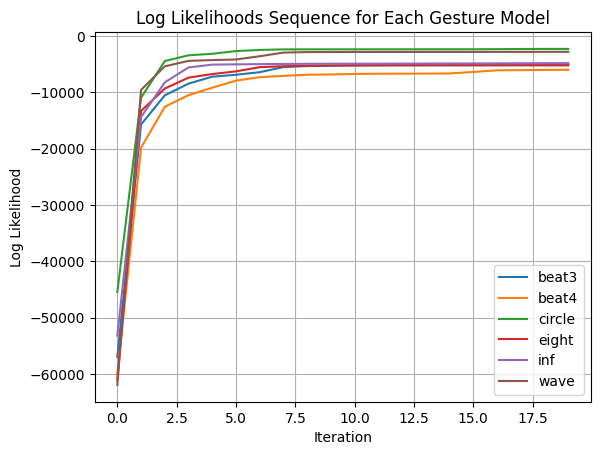

In [ ]:
np.set_printoptions(threshold=np.inf)

log_pi_init = initialize_initial_state_distribution(hidden_states)
log_trans_mat_init = initialize_left_to_right_transition_matrix(hidden_states)
log_em_mat_init = initialize_emission_matrix(hidden_states, obs_types)

likelihood_sequence_dictionary = {}
gestures_list = ['beat3', 'beat4', 'circle', 'eight', 'inf', 'wave']
for gesture in gestures_list:
    print(f"Training HMM for {gesture} motion...")
    dfs = [df for df in train_repeated_data if df['label'].iloc[0] == gesture]
    O = np.concatenate([df['cluster'].astype(int).values for df in dfs])

    trans_mat, em_mat, likelihood, likelihoods_sequence = baum_welch(log_trans_mat_init, log_em_mat_init, log_pi_init, O, obs_types, max_iter=20)
    print(f'for gesture {gesture} trans mat is \n {trans_mat} \n em mat is \n {em_mat} \n log likelihood is {likelihood}')
    trained_model_dict = {'transition_matrix': trans_mat, 'emission_matrix': em_mat}
    likelihood_sequence_dictionary[gesture] = likelihoods_sequence

    model_filename = f'combined_trained_model_{gesture}.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(trained_model_dict, f)

likelihoods_dictionary_filename = 'likelihoods_sequences_combined.pkl'
with open(likelihoods_dictionary_filename, 'wb') as f:
    pickle.dump(likelihood_sequence_dictionary, f)

# Plotting the likelihood sequences
for gesture, likelihood_sequence in likelihood_sequence_dictionary.items():
    plt.plot(likelihood_sequence, label=gesture)

plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihoods Sequence for Each Gesture Model')
plt.legend()
plt.grid(True)
plt.savefig('combined_likelihood_sequence_plot.png')
plt.show()

Test Trained Models on the Additional Training Data

In [ ]:
def initialize_initial_state_distribution(num_h_states):
    pi = np.zeros(num_h_states)
    pi[0] = 1  # Probability 1 for the first hidden state
    pi += EPSILON
    pi /= np.sum(pi)  # Normalize to ensure it sums to 1
    return np.log(pi)

# run predictions
def get_likelihood_of_data_with_model(trans_mat,em_mat,num_h_states,seq_obs):
    log_trans_mat = np.log(trans_mat)
    log_em_mat = np.log(em_mat)
    log_init_pi = initialize_initial_state_distribution(num_h_states)
    log_alpha = forward(log_trans_mat,log_em_mat,log_init_pi,seq_obs)
    log_likelihood = calc_log_likelihood(log_alpha)
    return log_likelihood

In [ ]:
def predict_gesture(model_dict, observation_sequence):
    trans_mat = model_dict['transition_matrix']
    em_mat = model_dict['emission_matrix']
    num_h_states = trans_mat.shape[0]

    log_likelihood = get_likelihood_of_data_with_model(trans_mat, em_mat, num_h_states, observation_sequence)

    return log_likelihood

In [ ]:
# Load trained models
gesture_models = {}
for gesture in gestures_list:
    model_filename = f'combined_trained_model_{gesture}.pkl'
    with open(model_filename, 'rb') as f:
        gesture_models[gesture] = pickle.load(f)

In [ ]:
train_data_for_test = load_data(train_single_gesture_folder_path, False)

train_data_for_test_clusters = {}
train_data_for_test_filepaths = {}
for i,df in enumerate(train_data_for_test):
    features = df[['Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az']]
    features_imputed = imputer.transform(features)  # Using the imputer fitted on the training data
    clusters = kmeans.predict(features_imputed)  # Using the kmeans fitted on the training data
    train_data_for_test_clusters[i] = clusters
    train_data_for_test_filepaths[i] = df.iloc[0]['label']

['ECE5242Proj2-train-additional/beat3_31.txt', 'ECE5242Proj2-train-additional/beat4_31.txt', 'ECE5242Proj2-train-additional/circle31.txt', 'ECE5242Proj2-train-additional/eight31.txt', 'ECE5242Proj2-train-additional/inf31.txt', 'ECE5242Proj2-train-additional/wave31.txt']


In [ ]:
train_data_for_test_filepaths

{0: 'ECE5242Proj2-train-additional/beat3_31.txt',
 1: 'ECE5242Proj2-train-additional/beat4_31.txt',
 2: 'ECE5242Proj2-train-additional/circle31.txt',
 3: 'ECE5242Proj2-train-additional/eight31.txt',
 4: 'ECE5242Proj2-train-additional/inf31.txt',
 5: 'ECE5242Proj2-train-additional/wave31.txt'}

In [ ]:
# Store the results
results = []

# Make predictions
for idx, train_data_for_test_cluster in train_data_for_test_clusters.items():
    observation_sequence = train_data_for_test_cluster
    log_likelihoods = {}
    for gesture_name, model_dict in gesture_models.items():
        log_likelihood = predict_gesture(model_dict, observation_sequence)
        log_likelihoods[gesture_name] = log_likelihood

    # Sort the likelihoods dictionary by values (likelihoods) in descending order
    sorted_likelihoods = sorted(log_likelihoods.items(), key=lambda x: x[1], reverse=True)

    # Extract the top 3 predicted gestures
    top_3_predicted_gestures = [gesture_name for gesture_name, _ in sorted_likelihoods[:3]]

    # Store the top 3 predicted gestures
    results.append((train_data_for_test_filepaths[idx], top_3_predicted_gestures))

    # Store all likelihood values
    results.append((train_data_for_test_filepaths[idx], sorted_likelihoods))

# Print one set of the top 3 predicted gestures
print("Top 3 predicted gestures:")
for idx in range(0, len(results), 2):
    file_path, top_3_predicted_gestures = results[idx]
    print(f"train test file: {file_path}, Top 3 predicted gestures: {', '.join(top_3_predicted_gestures)}")

# Print one set showing all likelihood values
print("\nAll likelihood values:")
for idx in range(1, len(results), 2):
    file_path, sorted_likelihoods = results[idx]
    print(f"train test file: {file_path}")
    for gesture_name, likelihood in sorted_likelihoods:
        print(f"{gesture_name}: {likelihood}")
    print()


Top 3 predicted gestures:
train test file: ECE5242Proj2-train-additional/beat3_31.txt, Top 3 predicted gestures: beat3, beat4, wave
train test file: ECE5242Proj2-train-additional/beat4_31.txt, Top 3 predicted gestures: beat4, beat3, inf
train test file: ECE5242Proj2-train-additional/circle31.txt, Top 3 predicted gestures: circle, beat4, beat3
train test file: ECE5242Proj2-train-additional/eight31.txt, Top 3 predicted gestures: eight, inf, beat3
train test file: ECE5242Proj2-train-additional/inf31.txt, Top 3 predicted gestures: inf, eight, wave
train test file: ECE5242Proj2-train-additional/wave31.txt, Top 3 predicted gestures: wave, beat3, beat4

All likelihood values:
train test file: ECE5242Proj2-train-additional/beat3_31.txt
beat3: -266.16601958459444
beat4: -318.87976993867346
wave: -12810.920646621142
inf: -24188.841428675492
eight: -25477.776091271695
circle: -26337.168121735886

train test file: ECE5242Proj2-train-additional/beat4_31.txt
beat4: -289.1315643911868
beat3: -1828.98

Test Models on Test Data

In [ ]:
test_data = load_data(test_folder_path, False)

test_data_clusters = {}
test_data_filepaths = {}
for i,df in enumerate(test_data):
    features = df[['Wx', 'Wy', 'Wz', 'Ax', 'Ay', 'Az']]
    features_imputed = imputer.transform(features)  # Using the imputer fitted on the training data
    clusters = kmeans.predict(features_imputed)  # Using the kmeans fitted on the training data
    test_data_clusters[i] = clusters
    test_data_filepaths[i] = df.iloc[0]['label']

['ECE5242Proj2-test/test1.txt', 'ECE5242Proj2-test/test2.txt', 'ECE5242Proj2-test/test3.txt', 'ECE5242Proj2-test/test4.txt', 'ECE5242Proj2-test/test5.txt', 'ECE5242Proj2-test/test6.txt', 'ECE5242Proj2-test/test7.txt', 'ECE5242Proj2-test/test8.txt']


In [ ]:
# Store the results
results = []

# Make predictions
for idx, test_data_cluster in test_data_clusters.items():
    observation_sequence = test_data_cluster
    log_likelihoods = {}
    for gesture_name, model_dict in gesture_models.items():
        log_likelihood = predict_gesture(model_dict, observation_sequence)
        log_likelihoods[gesture_name] = log_likelihood

    # Sort the likelihoods dictionary by values (likelihoods) in descending order
    sorted_likelihoods = sorted(log_likelihoods.items(), key=lambda x: x[1], reverse=True)

    # Extract the top 3 predicted gestures
    top_3_predicted_gestures = [gesture_name for gesture_name, _ in sorted_likelihoods[:3]]

    # Store the top 3 predicted gestures
    results.append((test_data_filepaths[idx], top_3_predicted_gestures))

    # Store all likelihood values
    results.append((test_data_filepaths[idx], sorted_likelihoods))

# Print one set of the top 3 predicted gestures
print("Top 3 predicted gestures:")
for idx in range(0, len(results), 2):
    file_path, top_3_predicted_gestures = results[idx]
    print(f"train test file: {file_path}, Top 3 predicted gestures: {', '.join(top_3_predicted_gestures)}")

# Print one set showing all likelihood values
print("\nAll likelihood values:")
for idx in range(1, len(results), 2):
    file_path, sorted_likelihoods = results[idx]
    print(f"train test file: {file_path}")
    for gesture_name, likelihood in sorted_likelihoods:
        print(f"{gesture_name}: {likelihood}")
    print()


Top 3 predicted gestures:
train test file: ECE5242Proj2-test/test1.txt, Top 3 predicted gestures: inf, eight, beat3
train test file: ECE5242Proj2-test/test2.txt, Top 3 predicted gestures: beat4, beat3, inf
train test file: ECE5242Proj2-test/test3.txt, Top 3 predicted gestures: inf, eight, beat3
train test file: ECE5242Proj2-test/test4.txt, Top 3 predicted gestures: beat4, beat3, wave
train test file: ECE5242Proj2-test/test5.txt, Top 3 predicted gestures: circle, beat4, beat3
train test file: ECE5242Proj2-test/test6.txt, Top 3 predicted gestures: eight, inf, wave
train test file: ECE5242Proj2-test/test7.txt, Top 3 predicted gestures: wave, eight, beat3
train test file: ECE5242Proj2-test/test8.txt, Top 3 predicted gestures: beat4, beat3, wave

All likelihood values:
train test file: ECE5242Proj2-test/test1.txt
inf: -471.7651514355121
eight: -10213.84390595529
beat3: -16258.463830964953
wave: -16560.578702539126
beat4: -18264.58267352254
circle: -30565.01807380173

train test file: ECE524